In [6]:
!pip install sqlalchemy psycopg2-binary
!pip install boto3
import boto3
import getpass
import pandas as pd
from sqlalchemy import create_engine

In [7]:
url = 'https://retail-sales-pipeline-drew.s3.amazonaws.com/retail_sales_dataset.csv'
df = pd.read_csv(url)
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [8]:
df.info()
df.describe(include='all')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [9]:
# 1. Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# 2. Extract Year, Month, Day from 'Date'
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# 3. Add a 'Revenue Verified' column to check math
df['Revenue Verified'] = df['Quantity'] * df['Price per Unit'] == df['Total Amount']

# 4. Check if all revenues match
print("Revenue match for all rows:", df['Revenue Verified'].all())

# 5. Drop the verification column (optional)
df.drop(columns='Revenue Verified', inplace=True)

# Preview result
df.head()

Revenue match for all rows: True


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Year,Month,Day
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,2023,11,24
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,2023,2,27
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,2023,1,13
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,2023,5,21
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,2023,5,6


In [10]:
# Replace with your actual values
host = input("Enter your DB host (e.g., retaildb.xxxxxx.rds.amazonaws.com): ")
port = '5432'
database = 'postgres'
username = 'postgres'
password = getpass.getpass("Enter your DB password:")

# Create SQLAlchemy engine
connection_string = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string)

# Upload your DataFrame to PostgreSQL
df.to_sql('retail_sales', engine, if_exists='replace', index=False)

# Test query
pd.read_sql('SELECT * FROM retail_sales LIMIT 5', engine)

Enter your DB password:··········


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Year,Month,Day
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,2023,11,24
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,2023,2,27
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,2023,1,13
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,2023,5,21
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,2023,5,6


##1. Sales Summarya## 1. Sales Summary

- Total sales (Total Amount) overall?
- Which product category sells the most
- Who are the top customers?

In [11]:
# Total sales
total_sales = df['Total Amount'].sum()
print("Total Sales:", total_sales)

# Sales by product category
sales_by_category = df.groupby('Product Category')['Total Amount'].sum()
print(sales_by_category)

# Top customer(s)
top_customers = df.groupby('Customer ID')['Total Amount'].sum().sort_values(ascending=False)
print(top_customers.head())

Total Sales: 456000
Product Category
Beauty         143515
Clothing       155580
Electronics    156905
Name: Total Amount, dtype: int64
Customer ID
CUST015    2000
CUST412    2000
CUST970    2000
CUST547    2000
CUST281    2000
Name: Total Amount, dtype: int64


## 2. Sales Trends Over Time

Month
1     36980
2     44060
3     28990
4     33870
5     53150
6     36715
7     35465
8     36960
9     23620
10    46580
11    34920
12    44690
Name: Total Amount, dtype: int64


<Axes: title={'center': 'Monthly Sales'}, xlabel='Month'>

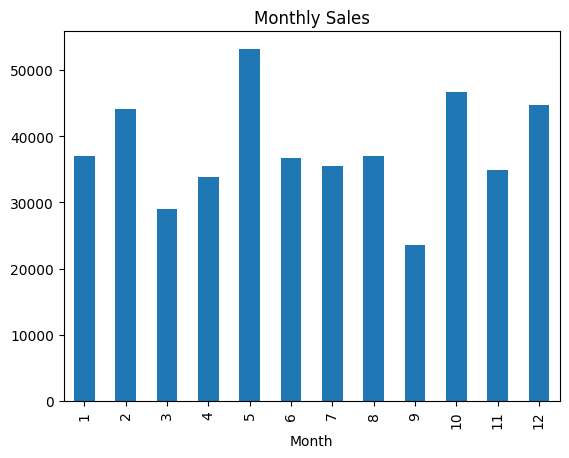

In [12]:
sales_by_month = df.groupby('Month')['Total Amount'].sum()
print(sales_by_month)
sales_by_month.plot(kind='bar', title='Monthly Sales')

## 3. Add Logic (Pipeline Step)

In [13]:
#Add a profit column (assuming fixed profit margin of 20%)
df['Profit'] = df['Total Amount'] * 0.2

## 4. Save the Processed File to S3 (Next Cloud Step)
- Save the DataFrame to a CSV.
- Upload it to your S3 bucket.

In [16]:
# Prompt for keys without showing them
aws_access_key_id = getpass.getpass('Enter your AWS Access Key ID: ')
aws_secret_access_key = getpass.getpass('Enter your AWS Secret Access Key: ')

s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

df.to_csv('processed_sales.csv', index=False)

s3.upload_file(
    Filename='processed_sales.csv',
    Bucket='retail-sales-pipeline-drew',
    Key='processed_sales.csv'
)

Enter your AWS Access Key ID: ··········
Enter your AWS Secret Access Key: ··········
